# 実験1: 各情報量の性質 → パラメータを変えて実験
結果: 差がある、ない、1つの図で比較して見られる


In [224]:
import numpy as np
from numpy.linalg import det
import var

def create_data():
    N = 2
    for d in np.arange(0, 1.0, 0.2):
        A = np.array([[0.03, d], [d, 0.03]])
        SigmaE = np.array([[0.2, 0.03], [0.03, 0.2]])

        initiali_state = np.random.multivariate_normal([0] * N, np.eye(N,N) * 0.1, size=1)[0]
        state_list = var.generate(initiali_state, A, SigmaE, N=10000)
        SigmaX = np.cov(state_list.T)
        yield {
            "d": d,
            "A": A,
            "SigmaE": SigmaE,
            "SigmaX": SigmaX,
            "state_list": state_list,
            "N": N,
            "mask": np.eye(N, N),
            "MI": 1 / 2 * np.log(det(SigmaX) / det(SigmaE))
        }

(0.0006311134703583201, 0.004552720072579564, 3.1936502976969704e-08)
(0.053570021066236456, 0.006063697817635716, 0.041334720518318914)
(0.16564247539210755, 0.02579676914484519, 0.17294309049395126)
(0.4421017613325952, 0.07694935608179587, 0.4435244731046036)
(1.086566500620252, 0.246396718504739, 0.9656632547144164)


,MI,gaii,geoii
0,0.000631,0.004553,3.193650e-08
1,0.053570,0.006064,4.133472e-02
2,0.165642,0.025797,1.729431e-01
3,0.442102,0.076949,4.435245e-01
4,1.086567,0.246397,9.656633e-01


<AxesSubplot:>

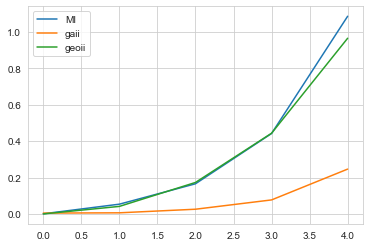

In [225]:
import gaii
import geoii
import pandas as pd
from IPython.display import display
result = []
for data in create_data():
    N = data["N"]
    model_gaii = gaii.fit_q(data["state_list"], data["mask"])
    gaii_result = model_gaii["js"]

    model_geoii = geoii.fit_q(data["A"], data["SigmaE"], data["SigmaX"], data["mask"])
    geoii_result = model_geoii["kl"]

    MI = data["MI"]
    print((MI, gaii_result, geoii_result))
    result.append((MI, gaii_result, geoii_result))
result = pd.DataFrame(result, columns=["MI", "gaii", "geoii"])
display(result)
result.plot()

# 実験2: 属性をクラスタリングできる

In [229]:
import numpy as np
from numpy.linalg import det
import var

def create_data():
    N = 4
    A = np.array([
        [0.4, 0.4, 0, 0],
        [0.4, 0.4, 0, 0],
        [0, 0, 0.4, 0.4],
        [0, 0, 0.4, 0.4],
    ])
    L = np.eye(N,N) * 1 + np.eye(N,N,k=1) * 0.7
    SigmaE = L @ L.T

    initiali_state = np.random.multivariate_normal([0] * N, np.eye(N,N) * 0.1, size=1)[0]
    state_list = var.generate(initiali_state, A, SigmaE, N=10000)
    SigmaX = np.cov(state_list.T)
    return {
        "A": A,
        "SigmaE": SigmaE,
        "SigmaX": SigmaX,
        "state_list": state_list,
        "N": N,
        "mask": np.eye(N, N),
        "MI": 1 / 2 * np.log(det(SigmaX) / det(SigmaE))
    }

(1.077262780895008, 0.038634894373727025, 0.6926004561803364)
(1.077262780895008, 0.03893053341181296, 0.8397140928619167)
(1.077262780895008, 0.07471692371637839, 0.5536919143952602)
(1.077262780895008, 0.021982489111733616, 0.4776277670649936)
(1.077262780895008, -0.005882861134695827, 5.960464100063265e-08)
(1.077262780895008, 0.055315075400185765, 0.5643477232541634)
(1.077262780895008, 0.07284843731195945, 0.4465914533396415)


,MI,gaii,geoii
"({0}, {1, 2, 3})",1.077263,0.038635,6.926005e-01
"({1}, {0, 2, 3})",1.077263,0.038931,8.397141e-01
"({2}, {0, 1, 3})",1.077263,0.074717,5.536919e-01
"({3}, {0, 1, 2})",1.077263,0.021982,4.776278e-01
"({0, 1}, {2, 3})",1.077263,-0.005883,5.960464e-08
"({0, 2}, {1, 3})",1.077263,0.055315,5.643477e-01
"({0, 3}, {1, 2})",1.077263,0.072848,4.465915e-01


<AxesSubplot:>

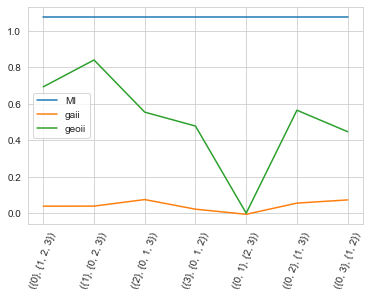

In [235]:
import gaii
import geoii
import pandas as pd
from IPython.display import display
import mip
data = create_data()
candidate_masks, candidate_list = mip.generate_masks(set(range(4)))

result = []
for mask in candidate_masks:
    N = data["N"]
    model_gaii = gaii.fit_q(data["state_list"], mask)
    gaii_result = model_gaii["js"]

    model_geoii = geoii.fit_q(data["A"], data["SigmaE"], data["SigmaX"], mask)
    geoii_result = model_geoii["kl"]

    MI = data["MI"]
    print((MI, gaii_result, geoii_result))
    result.append((MI, gaii_result, geoii_result))

result = pd.DataFrame(result, columns=["MI", "gaii", "geoii"], index=candidate_list)
display(result)
ax = result.plot()
ax.tick_params(axis='x', rotation=70)
ax

# 実験3: 実データで試してみた

In [ ]:
from statsmodels.tsa.api import VAR
def create_data():
    table = pd.read_table("stats.tsv", index_col="Date")
    display(table)
    table[["jp", "fr", "ge"]].plot()
    
    table_pct = table.pct_change()[["jp", "fr", "ge"]]
    table_pct.plot()
    table_pct = table_pct[1:-1].to_numpy()
    
    N = 3
    ar = VAR(table_pct).fit(trend="n", maxlags=1)
    initiali_state = np.random.multivariate_normal([0] * N, np.eye(N,N) * 0.01, size=1)[0]
    state_list = var.generate(initiali_state, ar.params, ar.sigma_u, N=10000)
    SigmaX = np.cov(state_list.T)
    return {
        "N": N,
        "A": ar.params,
        "SigmaE": ar.sigma_u,
        "SigmaX": SigmaX,
        "state_list": table_pct,
        "N": N,
        "mask": np.eye(N, N),
        "MI": 1 / 2 * np.log(det(SigmaX) / det(ar.sigma_u))
    }

data = create_data()
import mip
import gaii
import geoii
import pandas as pd
from IPython.display import display

N = data["N"]
candidate_masks, candidate_list = mip.generate_masks(set(range(N)))
result = []
for mask in candidate_masks:
    model_gaii = gaii.fit_q(data["state_list"], mask)
    gaii_result = model_gaii["js"]

    model_geoii = geoii.fit_q(data["A"], data["SigmaE"], data["SigmaX"], mask)
    geoii_result = model_geoii["kl"]

    MI = data["MI"]
    print((MI, gaii_result, geoii_result))
    result.append((MI, gaii_result, geoii_result))

result = pd.DataFrame(result, columns=["MI", "gaii", "geoii"], index=candidate_list)
display(result)
ax = result.plot()
ax.tick_params(axis='x', rotation=70)

# 実験４: 長期記憶のあるネットワークの利用

In [1]:
import numpy as np
from numpy.linalg import det
import var

def create_data():
    N = 4
    A = np.array([
        [0.4, 0.4, 0, 0],
        [0.4, 0.4, 0, 0],
        [0, 0, 0.4, 0.4],
        [0, 0, 0.4, 0.4],
    ])
    L = np.eye(N,N) * 1 + np.eye(N,N,k=1) * 0.7
    SigmaE = L @ L.T

    initiali_state = np.random.multivariate_normal([0] * N, np.eye(N,N) * 0.1, size=1)[0]
    state_list = var.generate(initiali_state, A, SigmaE, N=10000)
    SigmaX = np.cov(state_list.T)
    return {
        "A": A,
        "SigmaE": SigmaE,
        "SigmaX": SigmaX,
        "state_list": state_list,
        "N": N,
        "mask": np.eye(N, N),
        "MI": 1 / 2 * np.log(det(SigmaX) / det(SigmaE))
    }

In [34]:
import importlib
importlib.reload(gaii_lstm)

<module 'gaii_lstm' from '/Users/sasano/gaii/src/gaii_lstm.py'>

([0], [1, 2, 3])
Generator(
  (lstm1): LSTM(5, 1, num_layers=2)
  (lstm2): LSTM(7, 3, num_layers=2)
)
Discriminator(
  (lstm): LSTM(4, 4, num_layers=2)
  (fc_out): Linear(in_features=4, out_features=1, bias=True)
)
[Count 0/2000]    [JS: -0.245317] [G loss: -0.244776] [D loss: 0.245317]
[Count 100/2000]    [JS: -0.038240] [G loss: -0.002704] [D loss: 0.038240]
[Count 200/2000]    [JS: 0.113108] [G loss: 0.104022] [D loss: -0.113108]
[Count 300/2000]    [JS: 0.396509] [G loss: 0.466516] [D loss: -0.396509]
[Count 400/2000]    [JS: 0.586271] [G loss: 0.600849] [D loss: -0.586271]
[Count 500/2000]    [JS: 0.260666] [G loss: 0.045271] [D loss: -0.260666]
[Count 600/2000]    [JS: 0.233369] [G loss: 0.092019] [D loss: -0.233369]
[Count 700/2000]    [JS: 0.491467] [G loss: 0.569194] [D loss: -0.491467]
[Count 800/2000]    [JS: 0.479256] [G loss: 0.481569] [D loss: -0.479256]
[Count 900/2000]    [JS: 0.234793] [G loss: -0.037999] [D loss: -0.234793]
[Count 1000/2000]    [JS: 0.148318] [G loss:

,MI,gaii,geoii
"({0}, {1, 2, 3})",1.087693,0.296182,7.173929e-01
"({1}, {0, 2, 3})",1.087693,0.360889,8.579973e-01
"({2}, {0, 1, 3})",1.087693,12.985171,5.683739e-01
"({3}, {0, 1, 2})",1.087693,2.447558,5.018180e-01
"({0, 1}, {2, 3})",1.087693,0.770715,5.960464e-08
"({0, 2}, {1, 3})",1.087693,0.817470,5.613930e-01
"({0, 3}, {1, 2})",1.087693,0.665927,4.492500e-01


<AxesSubplot:>

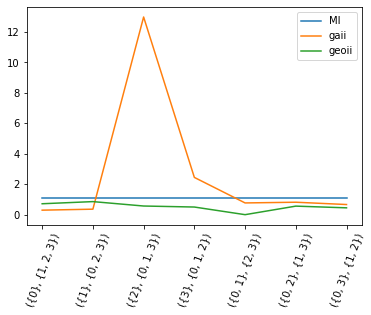

In [37]:
import gaii_lstm
import geoii
import pandas as pd
from IPython.display import display
import mip
data = create_data()
candidate_masks, candidate_list = mip.generate_masks(set(range(4)))

result = []
for mask, ls in zip(candidate_masks, candidate_list):
    N = data["N"]
    ls = (list(ls[0]), list(ls[1]))
    print(ls)
    model_gaii = gaii_lstm.fit_q(data["state_list"], ls, length=4, debug=True)
    gaii_result = model_gaii["js"]

    model_geoii = geoii.fit_q(data["A"], data["SigmaE"], data["SigmaX"], mask)
    geoii_result = model_geoii["kl"]

    MI = data["MI"]
    print((MI, gaii_result, geoii_result))
    result.append((MI, gaii_result, geoii_result))

result = pd.DataFrame(result, columns=["MI", "gaii", "geoii"], index=candidate_list)
display(result)
ax = result.plot()
ax.tick_params(axis='x', rotation=70)
ax

In [17]:
%debug

> /Users/sasano/gaii/src/gaii_lstm.py(59)forward()
     57 
     58     def forward(self, x, y):
---> 59         x_y = torch.cat((x, y), dim=0)
     60         _, (_, cn) = self.lstm(self.lstm1(x_y))
     61         hidden = cn[-1].view(-1, self.size)

tensor([[[ 4.3964e+00,  2.2210e+00, -1.7170e+00, -1.5264e+00],
         [ 2.4206e+00,  2.4026e+00,  4.5780e-01, -7.0811e-01],
         [ 1.3792e+00, -5.5425e-02,  7.6883e-02,  6.0663e-01],
         ...,
         [ 6.7606e-01, -1.0149e+00, -3.9733e-01,  6.1248e-01],
         [ 2.0004e+00,  4.3927e-01, -8.2825e-02, -7.5248e-01],
         [ 2.9315e+00,  3.0132e+00, -1.3289e+00, -1.7019e-01]],

        [[ 2.6394e+00,  2.9905e+00, -1.6681e+00, -1.8734e+00],
         [ 2.0271e+00,  3.5539e+00,  1.3795e+00, -6.6280e-02],
         [ 4.1259e-01, -5.2381e-01,  7.1188e-02,  1.0888e+00],
         ...,
         [ 4.6244e-01,  3.3663e-01,  6.6802e-01, -2.1950e-01],
         [-5.2635e-01,  6.5846e-02,  2.1048e+00,  1.4789e+00],
         [ 2.2614e+00,  